In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib notebook
import time
import torch
import torch.optim as optim
from tqdm import tqdm_notebook
from matic_pytorch import GP_adapter

<IPython.core.display.Javascript object>


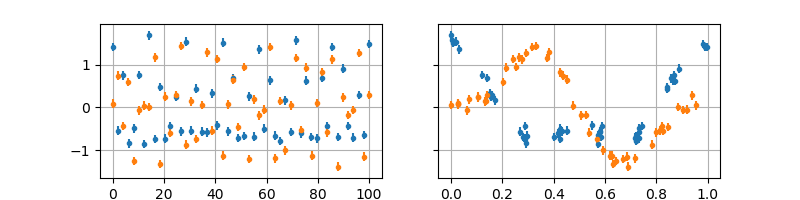

In [2]:
# Mock data to test
N = 50
s_noise = 0.1
per = np.array([1.4284, 0.8465])
t = np.linspace(0.0, 100.0, num=N)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 2), sharey=True)
lc_database = list()

t_uneven = t + 0.1*(10/N)*np.random.randn(N)
t_uneven = np.sort(t_uneven)
v_clean = np.cos(2.0*np.pi*t_uneven/per[0]) + 0.5*np.cos(4.0*np.pi*t_uneven/per[0]) 
v = v_clean + s_noise*np.random.randn(N)
e = s_noise*np.ones_like(v)
ax1.errorbar(t_uneven, v, e, fmt='.')
ax2.errorbar(np.mod(t_uneven, per[0])/per[0], v, e, fmt='.')   
lc_database.append({'data': torch.from_numpy(np.stack((t_uneven, v, e)).astype('float32').T), 
                    'period': per[0], 'label': 0})

t_uneven = t + 0.1*(10/N)*np.random.randn(N)
t_uneven = np.sort(t_uneven)
v_clean = np.sin(2.0*np.pi*t_uneven/per[1]) - 0.5*np.sin(4.0*np.pi*t_uneven/per[1]) 
v = v_clean + s_noise*np.random.randn(N)
e = s_noise*np.ones_like(v)
lc_database.append({'data': torch.from_numpy(np.stack((t_uneven, v, e)).astype('float32').T), 
                    'period': per[1], 'label': 1})
ax1.errorbar(t_uneven, v, e, fmt='.')
ax1.set_xlabel('Time'); ax1.grid()
ax2.errorbar(np.mod(t_uneven, per[1])/per[1], v, e, fmt='.')   
ax2.set_xlabel('Phase'); ax2.grid();

<IPython.core.display.Javascript object>


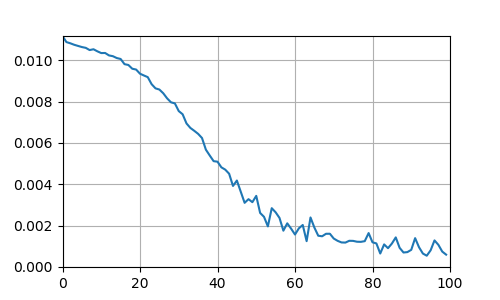

In [3]:
# Parameters
n_epoch = 100
net = GP_adapter(n_pivots=50, n_mc_samples=64, n_neuron_conv=32, kernel_size=5, n_classes=2)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
criterion = torch.nn.NLLLoss()

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
loss_history = list()
ax.plot(0, 0); ax.grid(); ax.set_label('Epoch')
line = ax.lines[0]
for k in tqdm_notebook(range(n_epoch), desc='Epochs'): 
    running_loss = 0.0
    for sample in lc_database: # data samples
        targets = torch.tensor(sample['label']).repeat(net.n_mc_samples)
        output = net(sample)
        optimizer.zero_grad()
        loss = criterion(output, targets)
        running_loss += loss.detach().numpy()/net.n_mc_samples
        loss.backward()
        optimizer.step()
    loss_history.append(running_loss/len(lc_database))
    line.set_xdata(range(k+1))
    line.set_ydata(loss_history)
    ax.set_xlim([0, k+1])
    ax.set_ylim([0, max(loss_history)])
    fig.canvas.draw();

In [4]:
 for i, sample in enumerate(lc_database):
    pred_proba = torch.exp(net.forward(sample)).detach().numpy()
    pred_label = np.argmax(np.mean(pred_proba, axis=0))
    print("%d: Predicted class %d, Average pbb:%f, std_dev:%f" %(i, pred_label, 
                                                                 np.mean(pred_proba, axis=0)[i], np.std(pred_proba, axis=0)[i]))

0: Predicted class 0, Average pbb:0.963305, std_dev:0.070753
1: Predicted class 1, Average pbb:0.966364, std_dev:0.135203


<IPython.core.display.Javascript object>


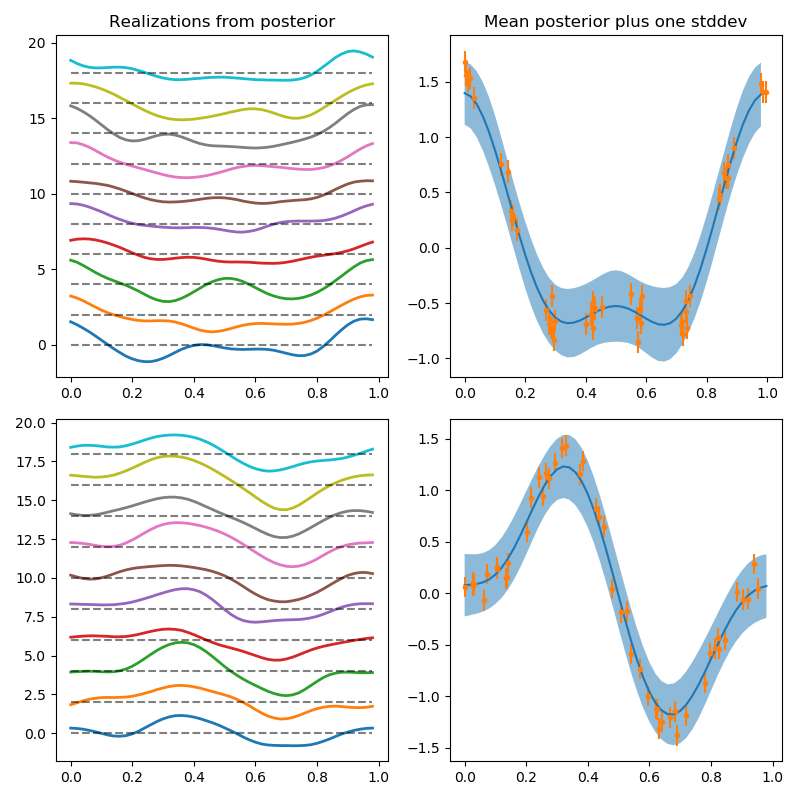

In [5]:
fig = plt.figure(figsize=(8, 8))

for i, sample in enumerate(lc_database):
    ax = fig.add_subplot(2, 2, 2*i+1)
    if i == 0:
        ax.set_title('Realizations from posterior')
    output, (mu, R, x) = net.forward(sample, return_gp=True)
    z = net.sample_from_posterior(mu, R).detach().numpy()
    x = x[0, :].detach().numpy()
    mu = mu[0, :].detach().numpy()
    s = torch.sqrt(torch.sum(R**2, dim=0)).detach().numpy()
    for k in range(10):
        ax.plot(x, 2*k+ z[k, :], linewidth=2)
        ax.plot(x, 2*k*np.ones(shape=x.shape), 'k--', alpha=0.5)
    ax = fig.add_subplot(2, 2, 2*i+2)
    if i == 0:
        ax.set_title('Mean posterior plus one stddev')    
    ax.plot(x, mu)
    ax.fill_between(x, mu  - s, mu +s, alpha=0.5)
    lc = sample['data'].detach().numpy()
    ax.errorbar(np.mod(lc[:, 0], sample['period'])/sample['period'], lc[:, 1], lc[:, 2], fmt='.')
plt.tight_layout();